# Week 7: Dimensionality Reduction

Many Machine Learning problems involve thousands or even millions of features for each training instance.
This has a few consequences:
* training becomes too slow
* it may be very difficult to find a good, let alone optimal, solution

This problem is often called the _curse of dimensionality_.

Fortunately, in real-world situations, it is possible to reduce the number of features. This makes problems tractable.

## Setup

In [1]:
# Python ≥3.8 is required
import sys
assert sys.version_info >= (3, 8)

# Scikit-Learn ≥1.0 is required
import sklearn
assert sklearn.__version__ >= "1.0"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

## 1. Principal Component Analysis (PCA)
 
This is by far the most popular dimensionality reduction algorithm. The goal of PCA is to project our dataset from high-dimensional hyperplane onto a lower-dimensional hyperplane.

PCA identifies the axis that accounts for the largest amount of variance in the training set. It then identifies the other $n-1$ axes, orthogonal to the first and each other, sorted by how much variance they accoynt for. The $i^{th}$ axis is called the $i^{th}$ principal component (PC) of the data.

The goal of PCA is to keep only those axis that significantly contribute to the variance in the data. The more the variance in the dataset the higher the information it contains.

To show how PCA works, let's first build a 3-D example dataset whose number of dimensions we want to reduce. 

The dataset represents an ellipsis lying on a 2D plane within the 3D space with some noise added to it.

In [2]:
np.random.seed(4)
m = 60  # number of samples
w1, w2 = 0.1, 0.3
noise = 0.1

angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5
X = np.empty((m, 3))
X[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * np.random.randn(m) / 2
X[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) / 2
X[:, 2] = X[:, 0] * w1 + X[:, 1] * w2 + noise * np.random.randn(m)

In [3]:
X[:5]

array([[-1.01570027, -0.55091331, -0.26132626],
       [-0.00771675,  0.59958572,  0.03507755],
       [-0.95317135, -0.46453691, -0.24920288],
       [-0.92012304,  0.21009593,  0.02182381],
       [-0.76309739,  0.158261  ,  0.19152496]])

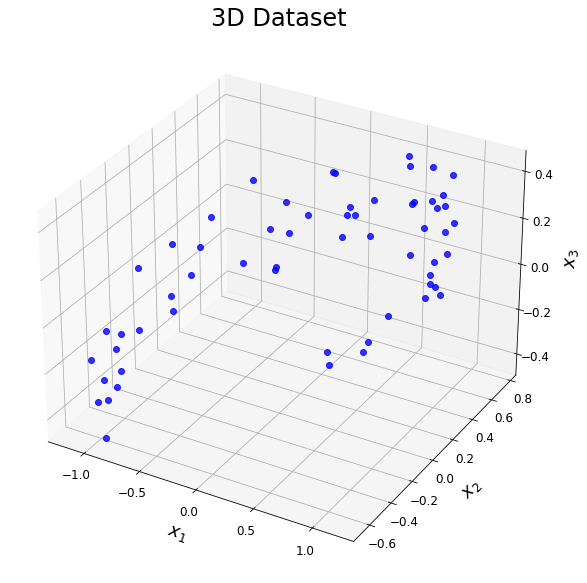

In [4]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection='3d')

# plot the dataset points
ax.plot(X[:, 0], X[:, 1], X[:, 2], "bo", alpha=0.8)


# add title and axis labels
ax.set_title("3D Dataset", fontsize=24)
ax.set_xlabel("$x_1$", fontsize=18, labelpad=10)
ax.set_ylabel("$x_2$", fontsize=18, labelpad=10)
ax.set_zlabel("$x_3$", fontsize=18, labelpad=10)

plt.show()

Let's get the 2 main components using scikit-learn's PCA transformer.

In [5]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X2D = pca.fit_transform(X)

In [6]:
X2D[:5]

array([[ 1.26203346,  0.42067648],
       [-0.08001485, -0.35272239],
       [ 1.17545763,  0.36085729],
       [ 0.89305601, -0.30862856],
       [ 0.73016287, -0.25404049]])

You can invert the transformation. However, keep in mind that there will be some information loss.

In [7]:
X3D_inv = pca.inverse_transform(X2D)

In [8]:
X3D_inv[:5]

array([[-1.01450604, -0.54656333, -0.27441525],
       [-0.02103231,  0.55108376,  0.18101894],
       [-0.95379477, -0.4668077 , -0.24237013],
       [-0.91717404,  0.22083765, -0.01049779],
       [-0.74607229,  0.22027492,  0.00492637]])

In [9]:
X[:5]

array([[-1.01570027, -0.55091331, -0.26132626],
       [-0.00771675,  0.59958572,  0.03507755],
       [-0.95317135, -0.46453691, -0.24920288],
       [-0.92012304,  0.21009593,  0.02182381],
       [-0.76309739,  0.158261  ,  0.19152496]])

The `PCA` object gives access to the principal components that it computed:

In [10]:
pca.components_

array([[-0.93636116, -0.29854881, -0.18465208],
       [ 0.34027485, -0.90119108, -0.2684542 ]])

Now, let's have a look at how much each component contributes to the dataset variance.

In [11]:
pca.explained_variance_ratio_

array([0.84248607, 0.14631839])

The first dimension explains 84.2% of the variance, while the second explains 14.6%.

In [12]:
lost_variance_percentage = (1-sum(pca.explained_variance_ratio_))*100
print(
    f'By reducing the data to 2 dimensions we lost {lost_variance_percentage:.2f} % of the variance'
)

By reducing the data to 2 dimensions we lost 1.12 % of the variance


## PCA: visualization

In [13]:
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d

class Arrow3D(FancyArrowPatch):
    """
    Utility class to draw a 3D arrow
    """
    def __init__(self, xs, ys, zs, *args, **kwargs):
        super().__init__((0,0), (0,0), *args, **kwargs)
        self._verts3d = xs, ys, zs

    def do_3d_projection(self, renderer=None):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, self.axes.M)
        self.set_positions((xs[0],ys[0]),(xs[1],ys[1]))

        return np.min(zs)

Let's first plot the 3D dataset, the plane and the projections on that plane:

In [14]:
# create a 3D grid for our 3D plot
axes = [-1.8, 1.8, -1.3, 1.3, -1.0, 1.0]

x1s = np.linspace(axes[0], axes[1], 10)
x2s = np.linspace(axes[2], axes[3], 10)
x1, x2 = np.meshgrid(x1s, x2s)

C = pca.components_
R = C.T.dot(C)
z = (R[0, 2] * x1 + R[1, 2] * x2) / (1 - R[2, 2])

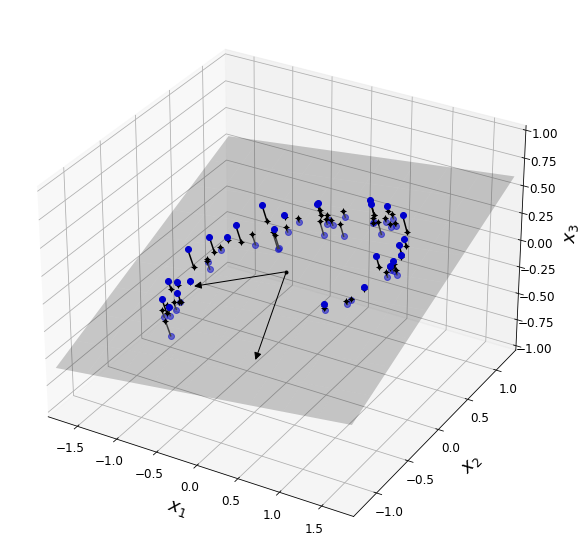

In [15]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection='3d')

# split the dataset into the items that lie above and below the 2D plane identified by PCA
X3D_above = X[X[:, 2] > X3D_inv[:, 2]]
X3D_below = X[X[:, 2] <= X3D_inv[:, 2]]

# first plot the dataset points lying below the PC plane
ax.plot(X3D_below[:, 0], X3D_below[:, 1], X3D_below[:, 2], "bo", alpha=0.5)

# plot the 2D PC place onto the 3D space
ax.plot_surface(x1, x2, z, alpha=0.2, color="k")
np.linalg.norm(C, axis=0)

# Add 3D arrow describing the principal components
ax.add_artist(Arrow3D([0, C[0, 0]],[0, C[0, 1]],[0, C[0, 2]], mutation_scale=15, lw=1, arrowstyle="-|>", color="k"))
ax.add_artist(Arrow3D([0, C[1, 0]],[0, C[1, 1]],[0, C[1, 2]], mutation_scale=15, lw=1, arrowstyle="-|>", color="k"))
ax.plot([0], [0], [0], "k.")

# draw (black) lines highlighting the projections of the sample points onto the PC plane
for i in range(m):
    if X[i, 2] > X3D_inv[i, 2]:
        ax.plot(
            [X[i][0], X3D_inv[i][0]], [X[i][1], X3D_inv[i][1]], [X[i][2], X3D_inv[i][2]], 
            "k-"
        )
    else:
        ax.plot(
            [X[i][0], X3D_inv[i][0]], [X[i][1], X3D_inv[i][1]], [X[i][2], X3D_inv[i][2]],
            "-",
            color="#505050"
        )


# plot the 3D samples as projected on the PC plane after PCA
ax.plot(X3D_inv[:, 0], X3D_inv[:, 1], X3D_inv[:, 2], "k+")
ax.plot(X3D_inv[:, 0], X3D_inv[:, 1], X3D_inv[:, 2], "k.")


# now plot the dataset points lying above the PC plane
ax.plot(X3D_above[:, 0], X3D_above[:, 1], X3D_above[:, 2], "bo")

# add labels and plot limits
ax.set_xlabel("$x_1$", fontsize=18, labelpad=10)
ax.set_ylabel("$x_2$", fontsize=18, labelpad=10)
ax.set_zlabel("$x_3$", fontsize=18, labelpad=10)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])

plt.show()

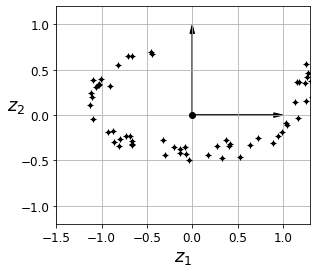

In [90]:
fig = plt.figure()
ax = fig.add_subplot(111, aspect='equal')

ax.plot(X2D[:, 0], X2D[:, 1], "k+")
ax.plot(X2D[:, 0], X2D[:, 1], "k.")
ax.plot([0], [0], "ko")
ax.arrow(0, 0, 0, 1, head_width=0.05, length_includes_head=True, head_length=0.1, fc='k', ec='k')
ax.arrow(0, 0, 1, 0, head_width=0.05, length_includes_head=True, head_length=0.1, fc='k', ec='k')
ax.set_xlabel("$z_1$", fontsize=18)
ax.set_ylabel("$z_2$", fontsize=18, rotation=0)
ax.axis([-1.5, 1.3, -1.2, 1.2])
ax.grid(True)
plt.show()

### PCA: under the hood

`scikit-learn`'s implementation of PCA uses Singular Value Decompositon (SVD) on the training set. SVD decomposes our $X$ features array into three components.

$\bf{X = U \Sigma V^T}$

The matrix $\bf{V}$ contains the unit vectors $\bf{c_i}$ that define our principal components

$\bf{V=(c_1, c_2, ..., c_n)}$

$\Sigma$ is a (rectangular) diagonal matrix containing the singular values associated to each principal components.

$\Sigma =  diag(\sigma_1, \sigma_2, ..., \sigma_n)$ 

The biggest the absolute value of a singular value $\mid{\sigma_i}\mid$ the more variance that principal components holds

### PCA form data compression: MNIST

We'll now use PCA to compress the MNIST dataset (e.g. as a data compression pre-processing step)

Each image in the MNIST dataset is 28x28 in size, hence it has 784 features (dimensions). However, not all these features are equally informative, so it could be a reasonable candidate for PCA.

In [91]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.target = mnist.target.astype(np.uint8)

Let's split the dataset into training and test set.

In [92]:
from sklearn.model_selection import train_test_split

X = mnist.data
y = mnist.target

X_train, X_test, y_train, y_test = train_test_split(X, y)

Let's first perform the PCA without reducing the dimensionality, and then find out the minimum number of dimensions necessary to preserve 95% of the training set variance.

In [93]:
pca = PCA()
pca.fit(X_train)
# compute the cumulative sum of the `explained_variance_ratio_` array
cumsum = np.cumsum(pca.explained_variance_ratio_)
# find the first index in the cumsum array whose value >= 0.95 (95%)
n_dims = np.argmax(cumsum >= 0.95) + 1

In [94]:
n_dims

154

So you need 154 dimensions out of the original 784 ($28 \times 28$) to preserve 95% of the variance.

You can also specify how much variance you want to preserve directly in the PCA constructor, using the argument `n_components`.

In [95]:
pca = PCA(n_components=0.95)
X_reduced = pca.fit_transform(X_train)

In [96]:
X_reduced.shape

(52500, 154)

We can now check how many features) i.e. pixels, would be enough to explain 95% of the variance.

In [97]:
pca.n_components_

154

In [98]:
np.sum(pca.explained_variance_ratio_)

0.9503684424557436

You can now reconstruct back the original 784-D images (with a 5% variance loss) from the compressed 154-D dataset.

In [99]:
X_reconstructed = pca.inverse_transform(X_reduced)

Let's see how the reconstructed images compare to the original ones.

Text(0.5, 1.0, 'Compressed')

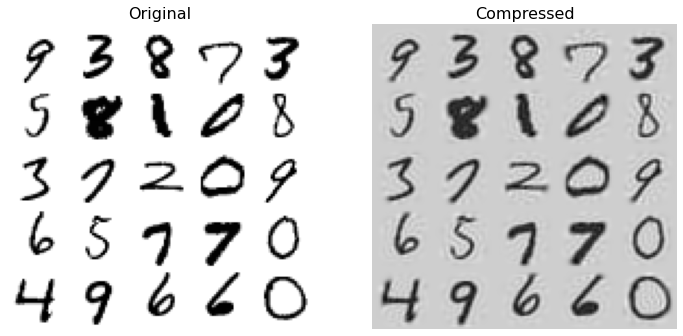

In [100]:
def plot_digits(instances, images_per_row=5, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

plt.figure(figsize=(12, 10))
plt.subplot(121)
plot_digits(X_train[::2100])
plt.title("Original", fontsize=16)
plt.subplot(122)
plot_digits(X_reconstructed[::2100])
plt.title("Compressed", fontsize=16)

As you can see, even though there has been some information loss, the digits are still clearly recognizable.

**Exercise:** perform the PCA transformation on the test set.

In [ ]:
# Write solution here.

# THIS IS A START - ADAPT

from sklearn.datasets import load_iris
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Load iris dataset
iris = load_iris()
X = iris.data
y = iris.target

# Initialize PCA object with desired number of components
pca = PCA(n_components=2)

# Fit and transform the data into the lower-dimensional space
X_pca = pca.fit_transform(X)

# Plot the transformed data
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y)
plt.title('PCA visualization of Iris dataset')
plt.show()


## 2. Other dimensionality reduction techniques:

* Manifold Learning
* Autoencoders (we'll see an intro on these later in the course)

### 2.1 Manifold learning: the UMAP algorithm

*Manifold learning* is a class of unsupervised estimators that seeks to describe high-dimensional datasets as low-dimensional manifolds embedded in high-dimensional spaces. They are mostly used for visualization purposes.

Manifold Learning can be thought of as an attempt to generalize linear frameworks like PCA to be sensitive to non-linear structure in data. Though supervised variants exist, the typical manifold learning problem is unsupervised: it learns the high-dimensional structure of the data from the data itself, without the use of predetermined classifications.

PCA is a linear projection, which means it can’t capture non-linear dependencies. Manifold learning techniques are able to preserve the local structure of the data when projecting it to lower dimensions. A manifold is strictly defined a topological space that "locally" resembles Euclidean space, but this does not help us much. Some example of manifolds could help us understand it better. The surface of a sphere or a torus (i.e. a "doughnut") or a Moebius strip are examples of a 2D manifold embedded in a 3D space. Manifold learning aims at learning M-dimensional manifolds from an N-dimensional dataset where N > M (or even N >> M).

There are a few widely used manifold learning algorithms:
   * Isomap
   * Locally Linear Embedding (LLE)
   * T-distributed Stochastic Neighbor Embedding (t-SNE)
   * Uniform Manifold Approximation and Projection (UMAP)

The first three algorithms can be found on `scikit-learn`. We will now briefly see UMAP. You will have to install
UMAP either using Anaconda Navigator or by running `!conda install -c conda-forge umap-learn` on a notebook cell (you can also run it on a terminal without the exclamation mark).

UMAP is a dimension reduction technique that can be used for visualisation, but also for general non-linear dimension reduction.

We'll split again the MNIST dataset into training and test set.

In [101]:
X, y = mnist.data, mnist.target

# use slicing to create training and test set
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

Let's just create a UMAP reducer and train it on our training set. We'll then transform our training set.

In [102]:
import umap

reducer = umap.UMAP(
    n_components=2, # by default learn a 2D manifold
    random_state=77
)
reducer.fit(X_train)
embedding = reducer.transform(X_train)

Let's plot the results:

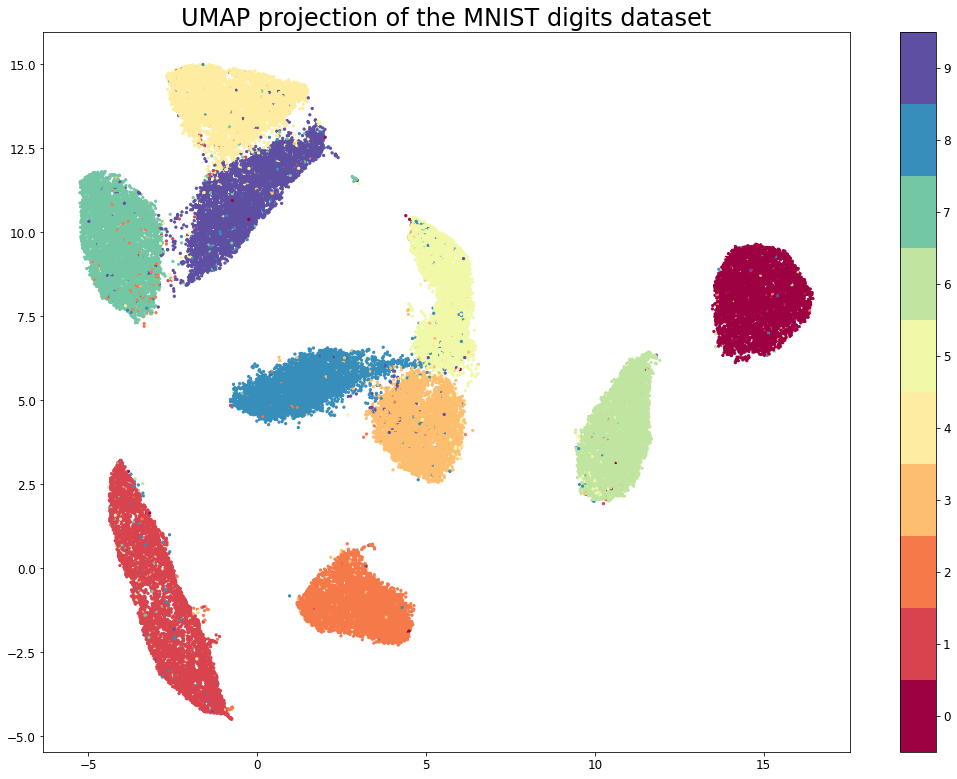

In [103]:
fig = plt.figure(figsize=(14, 10))
# I am taking all the space inside the figure
ax = fig.add_axes([0, 0, 1, 1])

scatter = ax.scatter(
    embedding[:, 0], # first dimension of the resulting embedding
    embedding[:, 1], # second dimension of the resulting embedding
    c=y_train, # colour the dots by class (i.e. digit)
    cmap='Spectral',
    s=5 # size of the dots
)
ax.set_title('UMAP projection of the MNIST digits dataset', fontsize=24)
fig.colorbar(scatter, boundaries=np.arange(11)-0.5).set_ticks(np.arange(10))
fig.gca().set_aspect('equal', 'datalim')

As you can see the instances of our training set seem to cluster based on the actual class value. Notice that we haven't used the class for training, this is purely unsupervised learning.

**Exercise:** visualize the manifold embedding of the test set

**Exercise:** try a different manifold learning technique out of `scikit-learn` (e.g. t-SNE) and visualize the embeddings.

1. <b>Principal Component Analysis (PCA)</b>: a linear method that finds the directions of maximum variance in the data and projects the data onto a lower-dimensional space.
2. <b>Locally Linear Embedding (LLE) </b>: a non-linear method that seeks to preserve local relationships between neighboring data points, while ignoring global structure.
3. <b>Isomap</b>: a non-linear method that uses the geodesic distances (shortest paths along the manifold) between points to construct a low-dimensional embedding that preserves the global geometry of the data.
4. <b>t-SNE</b>: a non-linear method that tries to preserve the similarity between points in the high-dimensional space by minimizing the divergence between the high-dimensional and low-dimensional probability distributions of pairwise similarities.
5. <b>Spectral Embedding</b>: a non-linear method that constructs a low-dimensional embedding based on the spectral decomposition of a similarity graph built from the data.
6. <b>Multidimensional Scaling (MDS) </b>: a method that seeks to preserve the pairwise distances between points in the high-dimensional space by projecting them into a lower-dimensional space.
7. <b>Linear Discriminant Analysis (LDA) </b>: a method that maximizes the separation between classes in a supervised setting, by finding a projection that maximizes the ratio of between-class variance to within-class variance.

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

# Generate random data
X = np.random.randn(100, 50)

# Initialize t-SNE object with desired parameters
tsne = TSNE(n_components=2, perplexity=30, learning_rate=200)

# Fit and transform the data into the lower-dimensional space
X_tsne = tsne.fit_transform(X)

# Plot the transformed data
plt.scatter(X_tsne[:, 0], X_tsne[:, 1])
plt.title('t-SNE visualization')
plt.show()